In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns                       
import matplotlib.pyplot as plt
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor

#import file
banks_ext_df = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')


In [ ]:
### Prepare data for experimentation
### by dropping columns already identifies as misc,
### binning and one-hot encoding categorical variables

# drop previously engineered fields since we have no information about them;
# also drop day_of_week since little variance from day to day
df = banks_ext_df.drop(["day_of_week", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m","nr.employed","duration"], axis=1)

# convert y int
df["y"] = df['y'].replace({'yes': 1, 'no': 0})

# make  varible for contacted status
# set pdays null values to NAs
df['pdays'] = df['pdays'].replace(999, -1)
df["was_contacted_before"] = (df["pdays"] != -1).astype(int)
df["pdays"] = df["pdays"].replace(-1, np.nan)

# convert month
month_mapping = {
    'jan': 0,
    'feb': 1,
    'mar': 2,
    'apr': 3,
    'may': 4,
    'jun': 5, 
    'jul': 6, 
    'aug': 7,
    'sep': 8, 
    'oct': 9, 
    'nov': 10, 
    'dec': 11
}
df['month'] = df['month'].map(month_mapping)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Make list of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
encoded_cols = []

# convert categoricals to integer encoded categorical
for i, col in enumerate(categorical_cols):
    df[col + "_encoded"] = le.fit_transform(df[col])
    encoded_cols.append(col + "_encoded")

df_encoded = df.drop(columns=categorical_cols).drop(columns=["pdays"])
print(df_encoded.head())

   age  month  campaign  previous  y  was_contacted_before  job_encoded  \
0   56      4         1         0  0                     0            3   
1   57      4         1         0  0                     0            7   
2   37      4         1         0  0                     0            7   
3   40      4         1         0  0                     0            0   
4   56      4         1         0  0                     0            7   

   marital_encoded  education_encoded  default_encoded  housing_encoded  \
0                1                  0                0                0   
1                1                  3                1                0   
2                1                  3                0                2   
3                1                  1                0                0   
4                1                  3                0                0   

   loan_encoded  contact_encoded  poutcome_encoded  
0             0                1             

<positron-console-cell-21>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [ ]:
# Alternative categorical encoding with 
# one-hot encode categorical works but adds unnecessary dimensions


# group/bin education values for dimensionality reduction
education_bins = {
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "secondary",
    "high.school": "secondary",
    "university.degree": "tertiary",
    "professional.course": "other",
    "unknown": "other",
    "illiterate": "other"
}
df["edu_group"] = df["education"].map(education_bins)

# one-hot encode categorical works but adds unnecessary dimensions
banks_onehot_df = pd.get_dummies(df, drop_first=True)

# convert boolean values from 1-hot encoding to integer
bool_cols = banks_onehot_df.select_dtypes(include="bool").columns
banks_onehot_df[bool_cols] = banks_onehot_df[bool_cols].astype(int)
# Make list of numerical cols
numeric_cols = banks_onehot_df.select_dtypes(include=["int64", "float64"]).columns
# use categorical labeling to avoid adding dimensions


In [24]:
# column types
print('\nColumn Types and Non-null Values')
print('\n__Extended DF:__\n', df_encoded.info())


Column Types and Non-null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   age                   41188 non-null  int64
 1   month                 41188 non-null  int64
 2   campaign              41188 non-null  int64
 3   previous              41188 non-null  int64
 4   y                     41188 non-null  int64
 5   was_contacted_before  41188 non-null  int64
 6   job_encoded           41188 non-null  int64
 7   marital_encoded       41188 non-null  int64
 8   education_encoded     41188 non-null  int64
 9   default_encoded       41188 non-null  int64
 10  housing_encoded       41188 non-null  int64
 11  loan_encoded          41188 non-null  int64
 12  contact_encoded       41188 non-null  int64
 13  poutcome_encoded      41188 non-null  int64
dtypes: int64(14)
memory usage: 4.4 MB

__Extended DF:__
 None


In [ ]:
# split data into training and testing datasets
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# create subsets for predictors (X) and dependent variable (y)
predictors =  df.drop(columns=categorical_cols).drop(columns=["pdays"]).columns
X = df[predictors]
y = df["y"]

# split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# what are our distributions?
print("Original class distribution:\n", y.value_counts(normalize=True))
print("\nTraining set class distribution:\n", y_train.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# address imbalance in training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nTraining set class distribution before SMOTE: {Counter(y_train)}")
print(f"\nTraining set class distribution after SMOTE: {Counter(y_train_resampled)}")



Index(['age', 'month', 'campaign', 'previous', 'y', 'was_contacted_before',
       'job_encoded', 'marital_encoded', 'education_encoded',
       'default_encoded', 'housing_encoded', 'loan_encoded', 'contact_encoded',
       'poutcome_encoded'],
      dtype='object')
Original class distribution:
 y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

Training set class distribution:
 y
0    0.887343
1    0.112657
Name: proportion, dtype: float64

Testing set class distribution:
 y
0    0.887351
1    0.112649
Name: proportion, dtype: float64

Training set class distribution before SMOTE: Counter({0: 25583, 1: 3248})

Training set class distribution after SMOTE: Counter({0: 25583, 1: 25583})


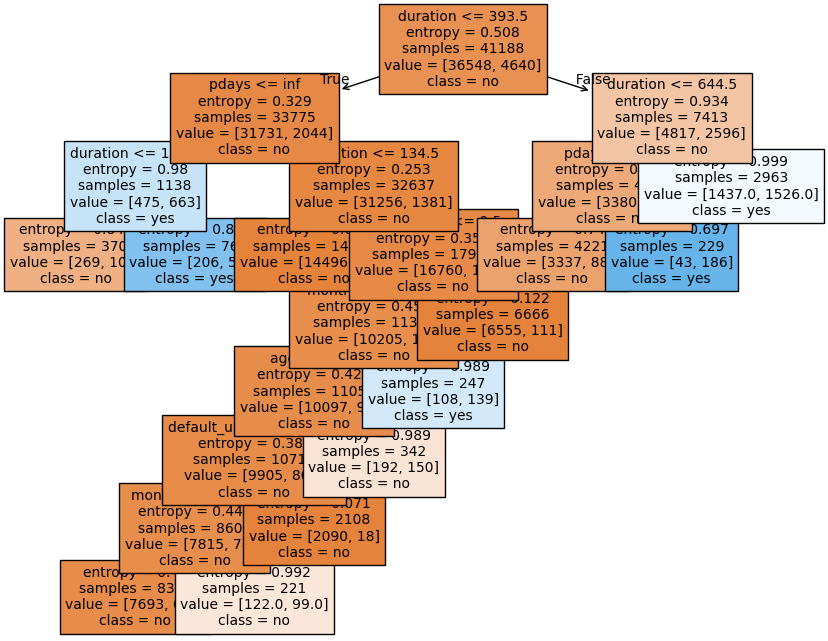

In [ ]:
# Decision Trees
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import dmba





bank_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', min_impurity_decrease=0.003)
bank_tree.fit(X, y)
#plotDecisionTree(bank_tree, feature_names=all_predictors, class_names=bank_tree.classes_)

plt.figure(figsize=(10, 8))
plot_tree(bank_tree, 
               feature_names=all_predictors,
               class_names=bank_tree.classes_,
               filled=True, 
               fontsize=10)
plt.show()

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)

rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)
rf.fit(X, y)


/home/pi/Documents/Data622/myvenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


KeyboardInterrupt: 

In [ ]:

n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', max_depth=5, random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

df = pd.DataFrame({ 'n' : n_estimator, 'oobScore' : oobScores })
df.plot(x='n', y='oobScore')

In [ ]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

#prediction.loc[predictions.prediction='1']

In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=bank_tree, n_estimator=500, learning_rate=0.1, random_state=1)
tree = bank_tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
#tree_train = accuracy_score(y_train, y_train_pred)
#tree_test = accuracy_score(y_train, y_test_pred)
#print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/tree_test:.3f') 
